In [135]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [136]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease                          
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease              
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease        
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 1s (196 kB/s)
Reading package lists... Done
W: Skipping acqui

In [137]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [138]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [141]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [142]:
print(df['label'].unique())


['Non Informative' 'Cyclone' 'Anthropogenic' 'Earthquake' 'River Erosion'
 'flood']


In [143]:
import pandas as pd

# Define the mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[1 4 2 3 0]


In [144]:
print(df['label'].value_counts())

label
4    697
0    510
1    509
2    500
3    445
Name: count, dtype: int64


In [145]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [146]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Prepare data for TextDataset
X_train = train_data['caption'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values


In [147]:
import random

# Random Deletion
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

# Random Swap
def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Character-level Noise
def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

# Combine all augmentations
def augment_bengali_text(text):
    # Step 1: Random Deletion
    text = random_deletion_bn(text, p=0.1)
    # Step 2: Random Swap
    text = random_swap_bn(text, n=1)
    # Step 3: Character-level noise
    text = char_noise_bn(text, p=0.03)
    return text

# Apply augmentation to your dataset
df['caption_aug'] = df['caption'].apply(augment_bengali_text)

print(df[['caption', 'caption_aug']].head(10))  # Check a sample


                                                caption  \
410       মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন   
1483  ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...   
1578  গাজা ও ইউক্রেন যুদ্ধ নিয়ে যে সতর্কবার্তা দিল ...   
1534  চীনের শেয়ারবাজারে অস্থিরতা, বিনিয়োগকারীদের ব...   
1235  ইটভাটা ও কারখানার ধোঁয়ায় রাতের আকাশ কালো হয়...   
584   “তুরস্ক-সিরিয়া সীমান্তে ভূমিকম্পে ৪,০০০+ মানুষ...   
994   স্কুলের মাঠটি গত সপ্তাহেও ছিল, আজ সেখানে শুধু ...   
3137                   জুম আর্থে ঘূর্ণিঝড় দানার অবস্থান   
3127  ঘূর্ণিঝড়ের প্রভাবে টানা বৃষ্টি ও ঝোড়ো হাওয়ায় দ...   
486   সবকিছু হারিয়েও কিছু মানুষ এখনও লড়ে যাচ্ছে, বে...   

                                            caption_aug  
410       লাইন ঝড়ের তাণ্ডবে বডদ্ঔুকের মংলায় বিচ্ছিন্ন  
1483  ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...  
1578  সতর্কবার্তা ও ইউক্রেন যুদ্ধ নিয়ষ যে গাজা দিল ...  
1534             চীনের অস্থিরতাই শেয়ারবাজারে বড় ক্ষতি  
1235  ইটভাটা ও কারখানার আকাশ রাতের ধোঁয়ায় কালো যাচ...  
58

In [148]:
from transformers import DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Use DistilBERT's multilingual tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_ds = TextDataset(X_train, y_train, tokenizer)
valid_ds = TextDataset(X_valid, y_valid, tokenizer)
test_ds = TextDataset(X_test, y_test, tokenizer)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)


In [149]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [150]:
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DistilBERT for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased', num_labels=5
).to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.2)
total_steps = len(train_dl) * 25
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(25):
    if early_stop:
        print("Early stopping triggered")
        break
    
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for batch in tqdm(train_dl, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        # If you want to use class weights:
        # weighted_loss = torch.mean(loss * class_weights[labels])
        # For now, let’s assume no class weights:
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_dl)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in valid_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dl)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            early_stop = True


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 1, Training Loss: 1.5600, Training Accuracy: 29.89%
Validation Loss: 1.4486, Validation Accuracy: 39.10%


Epoch 2: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


Epoch 2, Training Loss: 1.2128, Training Accuracy: 57.21%
Validation Loss: 0.9363, Validation Accuracy: 72.93%


Epoch 3: 100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


Epoch 3, Training Loss: 0.7847, Training Accuracy: 78.63%
Validation Loss: 0.5936, Validation Accuracy: 83.46%


Epoch 4: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Epoch 4, Training Loss: 0.5222, Training Accuracy: 85.84%
Validation Loss: 0.4346, Validation Accuracy: 87.59%


Epoch 5: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Epoch 5, Training Loss: 0.3819, Training Accuracy: 90.16%
Validation Loss: 0.3815, Validation Accuracy: 89.10%


Epoch 6: 100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


Epoch 6, Training Loss: 0.3043, Training Accuracy: 92.17%
Validation Loss: 0.3403, Validation Accuracy: 90.60%


Epoch 7: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


Epoch 7, Training Loss: 0.2444, Training Accuracy: 93.55%
Validation Loss: 0.3344, Validation Accuracy: 90.60%


Epoch 8: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 8, Training Loss: 0.2077, Training Accuracy: 94.80%
Validation Loss: 0.3193, Validation Accuracy: 91.35%


Epoch 9: 100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


Epoch 9, Training Loss: 0.1686, Training Accuracy: 96.43%
Validation Loss: 0.3163, Validation Accuracy: 91.35%


Epoch 10: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Epoch 10, Training Loss: 0.1523, Training Accuracy: 96.37%
Validation Loss: 0.3141, Validation Accuracy: 90.60%


Epoch 11: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 11, Training Loss: 0.1248, Training Accuracy: 97.62%
Validation Loss: 0.3311, Validation Accuracy: 90.04%


Epoch 12: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 12, Training Loss: 0.1107, Training Accuracy: 97.93%
Validation Loss: 0.3137, Validation Accuracy: 90.98%


Epoch 13: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


Epoch 13, Training Loss: 0.0922, Training Accuracy: 98.56%
Validation Loss: 0.3242, Validation Accuracy: 91.35%


Epoch 14: 100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


Epoch 14, Training Loss: 0.0853, Training Accuracy: 98.37%
Validation Loss: 0.3179, Validation Accuracy: 91.17%


Epoch 15: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


Epoch 15, Training Loss: 0.0716, Training Accuracy: 98.81%
Validation Loss: 0.3179, Validation Accuracy: 91.35%


Epoch 16: 100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


Epoch 16, Training Loss: 0.0701, Training Accuracy: 98.87%
Validation Loss: 0.3293, Validation Accuracy: 90.98%


Epoch 17: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 17, Training Loss: 0.0651, Training Accuracy: 98.87%
Validation Loss: 0.3178, Validation Accuracy: 90.98%
No improvement in validation loss for 5 epochs. Stopping training.
Early stopping triggered


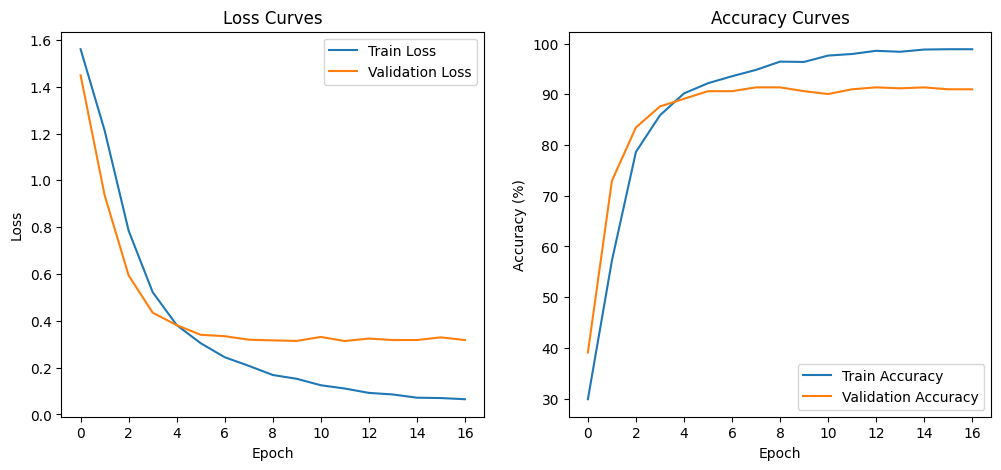

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.savefig('training_curves.png')  # Save the figure as a file

plt.show()


In [152]:
import pandas as pd

# Create a DataFrame for easy visualization
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses)+1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy (%)': train_accuracies,
    'Validation Accuracy (%)': val_accuracies
})

print(df)

# Optionally, save to a CSV file for later analysis
df.to_csv('training_metrics.csv', index=False)


    Epoch  Train Loss  Validation Loss  Train Accuracy (%)  \
0       1    1.560014         1.448636           29.887218   
1       2    1.212796         0.936293           57.205514   
2       3    0.784703         0.593562           78.634085   
3       4    0.522233         0.434602           85.839599   
4       5    0.381866         0.381465           90.162907   
5       6    0.304255         0.340289           92.167920   
6       7    0.244441         0.334356           93.546366   
7       8    0.207716         0.319294           94.799499   
8       9    0.168566         0.316350           96.428571   
9      10    0.152303         0.314092           96.365915   
10     11    0.124794         0.331112           97.619048   
11     12    0.110744         0.313682           97.932331   
12     13    0.092163         0.324214           98.558897   
13     14    0.085349         0.317903           98.370927   
14     15    0.071649         0.317891           98.809524   
15     1

Test Accuracy: 90.24%

Classification Report:
              precision    recall  f1-score   support

           0     0.9020    0.8762    0.8889       105
           1     0.8598    0.9109    0.8846       101
           2     0.9211    0.8898    0.9052       118
           3     0.8539    0.8837    0.8686        86
           4     0.9587    0.9431    0.9508       123

    accuracy                         0.9024       533
   macro avg     0.8991    0.9007    0.8996       533
weighted avg     0.9035    0.9024    0.9027       533



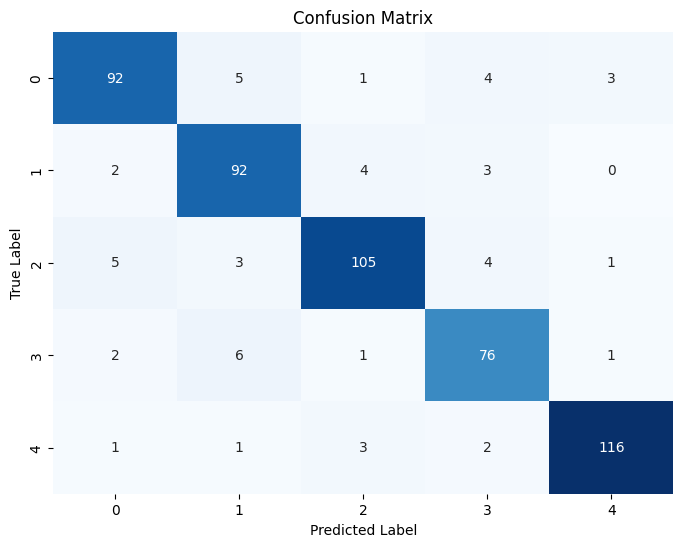

In [153]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = 100 * (sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels))
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
